# <p style="text-align: center;, font-style: strong;">Partie 1.2 - Entraînement d'un modèle à régression logistique</p>


## Dependencie

In [12]:
interp.load.ivy(
  coursier.Dependency(
    module = coursier.Module(coursier.Organization("org.platanios"), coursier.ModuleName("tensorflow_2.12")),
    version = "0.4.1",
    // replace with linux-gpu-x86_64 on linux with nvidia gpu or with darwin-cpu-x86_64 on macOS 
    attributes = coursier.Attributes(coursier.Type(""), coursier.Classifier("darwin-cpu-x86_64"))
  )
)

## Imports

In [13]:
import java.awt.{ Image => JImage }
import java.io.{ ByteArrayOutputStream, ByteArrayInputStream}
import scala.io.Source
import java.awt.image.BufferedImage
import java.awt.Color
import javax.imageio.ImageIO
import scala.util.Random
import java.util.Base64
import org.platanios.tensorflow.api.tf
import org.platanios.tensorflow.api.tensors.Tensor
import org.platanios.tensorflow.api.core.Shape
import org.platanios.tensorflow.api.core.client.{Session, FeedMap}

import java.awt.{ Image => JImage }

import java.io.{ ByteArrayOutputStream, ByteArrayInputStream}

import scala.io.Source

import java.awt.image.BufferedImage

import java.awt.Color

import javax.imageio.ImageIO

import scala.util.Random

import java.util.Base64

import org.platanios.tensorflow.api.tf

import org.platanios.tensorflow.api.tensors.Tensor

import org.platanios.tensorflow.api.core.Shape

import org.platanios.tensorflow.api.core.client.{Session, FeedMap}

In [14]:
def transformDataIntoTensors(pathData: String, widthImage: Int): (Tensor[Float], Tensor[Int]) = {
    val data = Source.fromFile(pathData).getLines.toList
    val numImages = data.length
    var dataNormalized: Array[Array[Double]] = Array.ofDim[Double](numImages, widthImage * widthImage)
    var labels: List[Int] = List()

    for ((line, index) <- data.zipWithIndex) {
        val splitLine = line.split(" ")
        val base64Decoded: Array[Byte] = Base64.getDecoder.decode(splitLine.head)
        val label = splitLine.last
        val bufferedImage = ImageIO.read(new ByteArrayInputStream(base64Decoded))
        labels = if (label == "green") 1 :: labels else 0 :: labels // 1 = green, 0 = blue
        for (x <- 0 until bufferedImage.getWidth) {
            for (y <- 0 until bufferedImage.getHeight) {
                val color = bufferedImage.getRGB(x, y)
                val green = ((color & 0x0000ff00) >> 8) / 255.0 // normalize
                dataNormalized(index)(x * widthImage + y) = green
            }
        }
    }

    val labelsTensor = Tensor(labels.reverse).reshape(Shape(numImages))
    val imagesTensor = Tensor(dataNormalized.flatten.toList).reshape(Shape(numImages, widthImage * widthImage)).toFloat // utiliser fill plus optimal je pense

    val tensorHotEncoded = tf.oneHot(labelsTensor, 2, 1, 0) // 2 = nb dimensions, 1 = on value, 0 = off value
    (imagesTensor, Session().run(fetches = tensorHotEncoded))
}

defined function transformDataIntoTensors

In [15]:
// Transform BufferedImage to a bytes Array
def convertBufferedImgToByteArray(buffImg: BufferedImage): Array[Byte] = {
    val baos = new ByteArrayOutputStream()
    ImageIO.write(buffImg, "png", baos)
    baos.toByteArray()
}

def resize(img: Array[Byte], height: Int, width: Int): Array[Byte] = {
    val bais = new ByteArrayInputStream(img)
    val bufferedImg = ImageIO.read(bais)
    val newImg = bufferedImg.getScaledInstance(width, height, JImage.SCALE_SMOOTH)
    val resized = new BufferedImage(width, height, BufferedImage.TYPE_INT_RGB)
    val g2d = resized.createGraphics()
    g2d.drawImage(newImg, 0, 0, null)
    g2d.dispose()
    convertBufferedImgToByteArray(resized)
}

// Generate a new blue-green color 
// initialGreen = First green choice randomly
// step = step to choose the new green color
// rnd = random generator
// RETURN a new green and blue value with 
// (green: Int = random value between [intialGreen - step, initialGreen + step], blue: Int = 255 - green)
def generateRandomColor(initialGreen: Int, step: Int, rnd: Random): (Int, Int) = {
    // handle border cases
    val start = if (initialGreen - step < 0) 0 else initialGreen - step
    val end = if (initialGreen + step > 255) 255 else initialGreen + step
    val randomGreen = start + rnd.nextInt((end - start) + 1)
    // new color is [r = 0, g = randomGreen, b = 255 - randomGreen]
    (randomGreen, 255 - randomGreen)
}

// Generate a random image
// size of the image, size = width = height
// step = step to choose the new green color
// rnd = random generator
// RETURN random image: BufferedImage
def generateRandomImage(size: Int, step: Int, rnd: Random): BufferedImage = {
    val rand = new Random(System.nanoTime)
    val image = new BufferedImage(size, size, BufferedImage.TYPE_INT_RGB)
    val initialGreen = rnd.nextInt(256) // random green between [0, 255]
    val initialBlue = (255 - initialGreen)
    for (x <- 0 until image.getWidth) {
        for (y <- 0 until image.getHeight) {
            // fill other with color depending from the initialGreen and the step variable
            val (newGreen, newBlue) = generateRandomColor(initialGreen, step, rnd)
            image.setRGB(x, y, new Color(0, newGreen, newBlue).getRGB)
        }
    }
    image
}

// Generate random image and convert it to base64 representation
// step = step to choose the new green color
// rnd = random generator
// RETURN String = base64 random image
def generateBase64Image(size: Int, step: Int, rnd: Random): String = {
    val buffImage: BufferedImage = generateRandomImage(size, step, rnd)
    val byteImage: Array[Byte] = convertBufferedImgToByteArray(buffImage)
    Base64.getEncoder.encodeToString(byteImage)
}

defined function convertBufferedImgToByteArray
defined function resize
defined function generateRandomColor
defined function generateRandomImage
defined function generateBase64Image

In [16]:
// Visualize results
def showAnswers(nameFile: String) {
    for (line <- Source.fromFile(nameFile).getLines) {
        val splitLine = line.split(" ")
        val base64Decoded: Array[Byte] = Base64.getDecoder.decode(splitLine.head)
        val image = Image(resize(base64Decoded, 100, 100)).withFormat(Image.PNG).display
        val label = splitLine.last
        println(label)
    }
}

defined function showAnswers

# TRAINING

### Parameters

In [17]:
val learningRate = 0.35f
val epochs = 100 // number of `iteration` in this case
val widthImage = 5
val pathData = "../resources/labels.txt"
val step = 20

val classNumber = 2 // blue or green

learningRate: Float = 0.35F
epochs: Int = 100
widthImage: Int = 5
pathData: String = "../resources/labels.txt"
step: Int = 20
classNumber: Int = 2

### Visualize

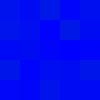

blue


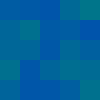

blue


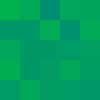

green


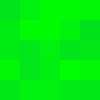

green


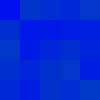

blue


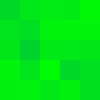

green


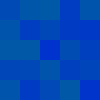

blue


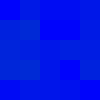

blue


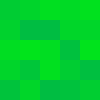

green


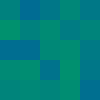

green


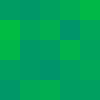

green


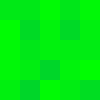

green


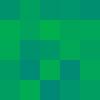

green


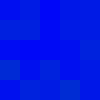

blue


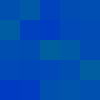

blue


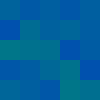

blue


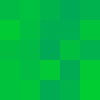

green


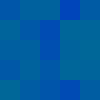

blue


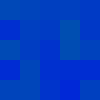

blue


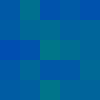

blue


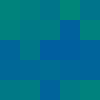

blue


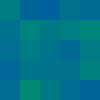

blue


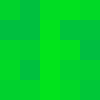

green


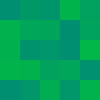

green


In [18]:
showAnswers(pathData)

### Model Creation

In [19]:
val sess = Session()
val sizeImage = widthImage * widthImage

val imagesPlaceholder = tf.placeholder[Float](Shape(-1, sizeImage))
val labelsPlaceholder = tf.placeholder[Float](Shape(-1, classNumber))

val W = tf.variable[Float]("weights", Shape(sizeImage, classNumber), tf.ZerosInitializer)
val B = tf.variable[Float]("biais", Shape(classNumber), tf.ZerosInitializer)

val labelsInfered = tf.sigmoid(tf.add(tf.matmul(imagesPlaceholder, W), B)) // model

val cost = tf.sigmoidCrossEntropy(logits = labelsInfered, labels = labelsPlaceholder) 

val optimizer = tf.train.GradientDescent(learningRate = learningRate).minimize(cost) 

sess.run(targets = tf.globalVariablesInitializer())

val (imagesTensor, labelsTensor) = transformDataIntoTensors(pathData, widthImage)

sess: Session = org.platanios.tensorflow.api.core.client.Session@175f8d67
sizeImage: Int = 25
imagesPlaceholder: org.platanios.tensorflow.api.ops.Output[Float] = Output(
  Placeholder_2,
  0
)
labelsPlaceholder: org.platanios.tensorflow.api.ops.Output[Float] = Output(
  Placeholder_3,
  0
)
W: tf.Variable[Float] = Variable(
  DataType("Float", 1, Some(4), DT_FLOAT),
  Output(weights, 0),
  weights/InitializationAssign,
  null,
  Output(weights/Read/ReadVariable, 0)
)
B: tf.Variable[Float] = Variable(
  DataType("Float", 1, Some(4), DT_FLOAT),
  Output(biais, 0),
  biais/InitializationAssign,
  null,
  Output(biais/Read/ReadVariable, 0)
)
labelsInfered: org.platanios.tensorflow.api.ops.Output[Float] = Output(
  Sigmoid_1,
  0
)
cost: org.platanios.tensorflow.api.ops.Output[Float] = Output(
  SigmoidCrossEntropy_1/Add,
  0
)
optimizer: org.platanios.tensorflow.api.ops.package.UntypedOp = Minimize_1/Finish
res18_9: org.platanios.tensorflow.api.implicits.helpers.OutputToTensor.<refinement>

### Training the model

In [20]:
for (e <- 1 to epochs) {
    sess.run(targets = optimizer, feeds = FeedMap(Map(imagesPlaceholder -> imagesTensor, labelsPlaceholder -> labelsTensor.toFloat))) 
}

val correct_prediction = tf.equal(tf.argmax(input = labelsInfered, axes = 1, outputDataType = Int), tf.argmax(input = labelsPlaceholder, axes = 1, outputDataType = Int))
val accuracy = sess.run(fetches = tf.mean(correct_prediction.toFloat), feeds = FeedMap(Map(imagesPlaceholder -> imagesTensor, labelsPlaceholder -> labelsTensor.toFloat))) 
println(s"Final accuracy = ${accuracy.scalar}")


Final accuracy = 1.0


correct_prediction: org.platanios.tensorflow.api.ops.Output[Boolean] = Output(
  Equal_1,
  0
)
accuracy: Tensor[Float] = Tensor[Float, []]

### Take back results from training

In [21]:
val weight = sess.run(fetches = W.value)
val biais = sess.run(fetches = B.value)
imagesTensor

weight: Tensor[Float] = Tensor[Float, [25, 2]]
biais: Tensor[Float] = Tensor[Float, [2]]
res20_2: Tensor[Float] = Tensor[Float, [24, 25]]

### Test our trained model

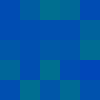

blue


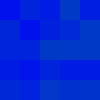

blue


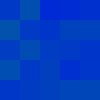

blue


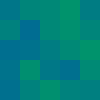

green


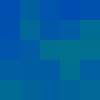

blue


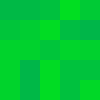

green


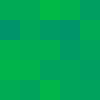

green


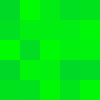

green


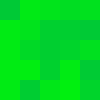

green


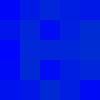

blue


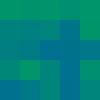

green


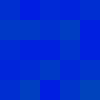

blue


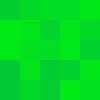

green


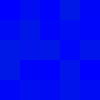

blue


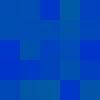

blue


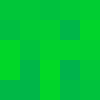

green


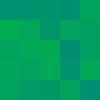

green


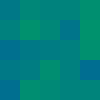

green


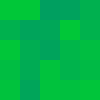

green


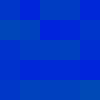

blue


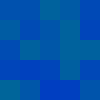

blue


rand: Random = scala.util.Random@58c7e096

In [22]:
val rand = new Random(System.nanoTime) // random generator for random images

for (i <- 0 to 20) {
    val newData: Array[Double] = Array.ofDim[Double](sizeImage)
    val img = generateBase64Image(widthImage, step, rand)
    val base64Decoded: Array[Byte] = Base64.getDecoder.decode(img)
    val bufferedImage = ImageIO.read(new ByteArrayInputStream(base64Decoded))
    val image = Image(resize(base64Decoded, 100, 100)).withFormat(Image.PNG).display

    for (x <- 0 until bufferedImage.getWidth) {
        for (y <- 0 until bufferedImage.getHeight) {
            val color = bufferedImage.getRGB(x, y)
            val green = ((color & 0x0000ff00) >> 8) / 255.0 // normalize
            newData(x * widthImage + y) = green
        }
    }


    val imagesTensor = Tensor(newData.toList).reshape(Shape(1, sizeImage))
    val prediction = sess.run(fetches = labelsInfered, feeds = FeedMap(Map(imagesPlaceholder -> imagesTensor.toFloat)))
    val labelDetected = Session().run(fetches = tf.argmax(prediction, 1, Int))
    if (labelDetected.scalar == 1) println("green") else println("blue")
}